In [1]:
from pathlib import Path
from pprint import pformat
import logging
import json
import re

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

logging.basicConfig(format='%(levelname)-8s [%(filename)s] %(message)s',
                    level=logging.INFO)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

time: 460 ms (started: 2023-02-22 05:05:13 +00:00)


INFO     [3739955635.py] ('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w50', 'train_logs', 'epoch_3350-20230218172431.json')


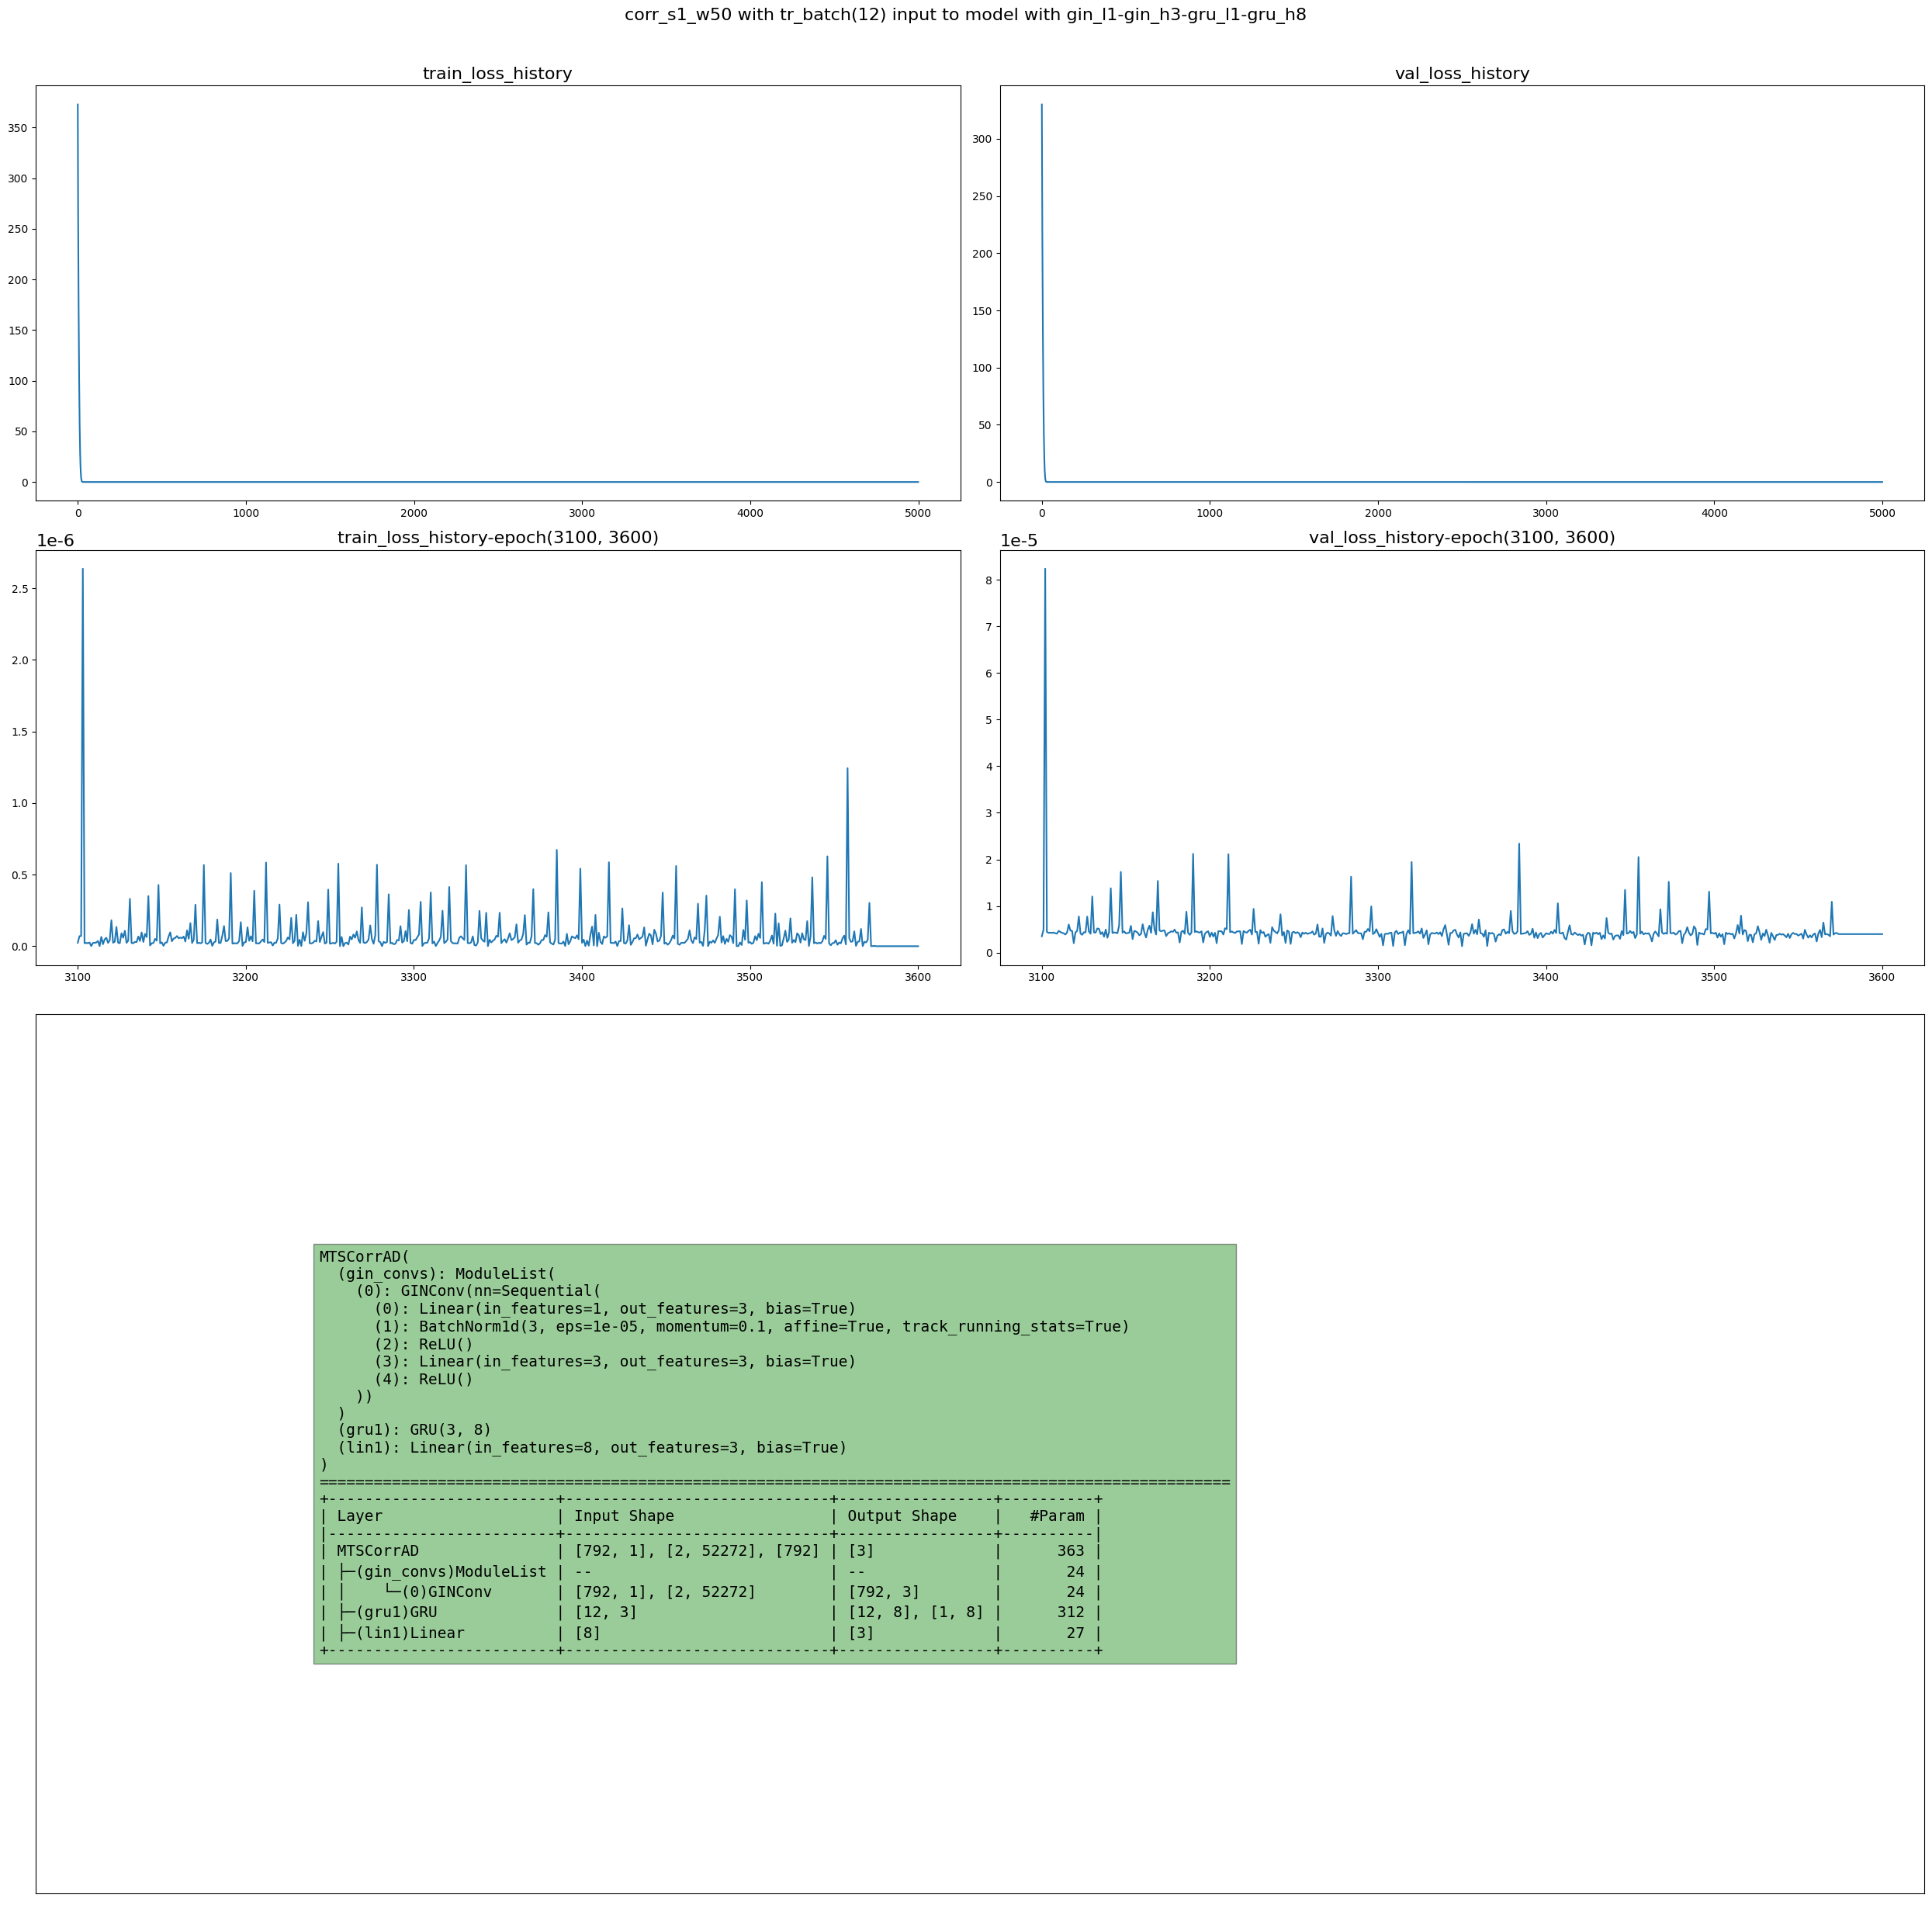

MTSCorrAD(
  (gin_convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=1, out_features=3, bias=True)
      (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=3, out_features=3, bias=True)
      (4): ReLU()
    ))
  )
  (gru1): GRU(3, 8)
  (lin1): Linear(in_features=8, out_features=3, bias=True)
)
+-------------------------+-----------------------------+-----------------+----------+
| Layer                   | Input Shape                 | Output Shape    |   #Param |
|-------------------------+-----------------------------+-----------------+----------|
| MTSCorrAD               | [792, 1], [2, 52272], [792] | [3]             |      363 |
| ├─(gin_convs)ModuleList | --                          | --              |       24 |
| │    └─(0)GINConv       | [792, 1], [2, 52272]        | [792, 3]        |       24 |
| ├─(gru1)GRU             | [12, 3]                     | [12, 8], [1,

In [2]:
mts_corr_model_log_dir = Path("./save_models/sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train/")

for log_path in mts_corr_model_log_dir.glob("**/*.json"):
    with open(log_path, "r") as source:
        log_dict = json.load(source)
        corr_info = log_path.parts[2]
        best_epoch = log_dict['best_val_epoch'] if log_dict.get('best_val_epoch') else 4500
        tr_batch = log_dict.get('train_batch') if log_dict.get('train_batch') else None
        if log_dict.get('model_structure'):
            gin_l = len(re.findall("\(\d\)GINConv", log_dict.get('model_structure')))
            gin_h = re.search("(\(\d\)\:\sGINConv.*\n.*)(out_features\=)(\d*)", log_dict.get('model_structure')).group(3)
            gru_l = re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure'))[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure')) else 1
            gru_h = re.search("(\(gru1\)\:.*)\,\s(\d*)", log_dict.get('model_structure')).group(2)
        else:
            gin_l = None
            gin_h = None
            gru_l = None
            gru_h = None
        logging.info(log_path.parts)
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(25,25))
    fig.suptitle(f'{corr_info} with tr_batch({tr_batch}) input to model with gin_l{gin_l}-gin_h{gin_h}-gru_l{gru_l}-gru_h{gru_h}', fontsize=16)
    gs = axs[0, 0].get_gridspec()
    # remove the upper axes
    for ncol in range(2):
        for ax in axs[2:, ncol]:
            ax.remove()
    axbig = fig.add_subplot(gs[2:, :2])
    axbig.set_xticks([]); axbig.set_yticks([])
    # axbig.annotate(text=f"{pformat(log_dict.get('model_structure'), indent=1, width=150, compact=True)}",
                   # xy=(0.15, 0.5), bbox={'facecolor': 'green', 'alpha': 0.4, 'pad': 5},
                   # fontsize=14, xycoords='axes fraction', va='center')
    axbig.annotate(text=f"{log_dict.get('model_structure').__str__()}",
                   xy=(0.15, 0.5), bbox={'facecolor': 'green', 'alpha': 0.4, 'pad': 5},
                   fontsize=16, fontfamily='monospace', xycoords='axes fraction', va='center')
    axs[0, 0].plot(log_dict.get('train_loss_history'))
    axs[0, 1].plot(log_dict.get('val_loss_history'))
    axs[1, 0].plot(log_dict.get('train_loss_history')[max(0, best_epoch-250):max(501, best_epoch+251)])
    axs[1, 1].plot(log_dict.get('val_loss_history')[max(0, best_epoch-250):max(501, best_epoch+251)])
    axs[0, 0].set_title('train_loss_history', fontsize=16)
    axs[0, 1].set_title('val_loss_history', fontsize=16)
    axs[1, 0].set_title(f"train_loss_history-epoch{(best_epoch-250, best_epoch+250)}", fontsize=16)
    axs[1, 1].set_title(f"val_loss_history-epoch{(best_epoch-250, best_epoch+250)}", fontsize=16)
    axs[1, 0].set_xticks(ticks=range(0, 501, 100), labels=[f"{x:02d}" for x in range(max(0, best_epoch-250), max(501, best_epoch+251), 100)])
    axs[1, 1].set_xticks(ticks=range(0, 501, 100), labels=[f"{x:02d}" for x in range(max(0, best_epoch-250), max(501, best_epoch+251), 100)])
    axs[0, 0].yaxis.offsetText.set_fontsize(16)
    axs[0, 1].yaxis.offsetText.set_fontsize(16)
    axs[1, 0].yaxis.offsetText.set_fontsize(16)
    axs[1, 1].yaxis.offsetText.set_fontsize(16)
    fig.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()
    plt.close()